# Generative Modeling exercises

In the first part of this notebook, we are doing the following:

1.   Clone the Git repository with the pretrained models
2.   Load necessary libraries
3.   Set up training loop
4.   Define generator and critic
5.   Train GAN
6.   Access generator performance

All the code is already written. Due to the long training times all models are pretrained. You simply have to load them. 

Then aim of the notebook is for you to get familiar with the the whole training setup in PyTorch and analyze the quality of the generated data.

Furthermore, we recommend that you think about it can be applied/adjusted to your own research. We highly recommend asking questions in this regard.

Note that the neural network classes and the training loop can be written in many different ways! This is just one way of doing it.


In [1]:
# Load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import pdb
import numpy as np
import imageio
from google.colab import drive
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
#drive.mount('/content/gdrive',force_remount=True)
#path = 'gdrive/MyDrive/Colab Notebooks/masterclass'
#os.chdir(path)

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/nmucke/computational_imaging_masterclass.git

Cloning into 'computational_imaging_masterclass'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 44 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [3]:
# Load MNIST training data
bs = 256

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), 
                         std=(0.5))
    ])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [4]:
# Train Wasserstein GAN

class TrainGAN():
    def __init__(self, generator, critic, generator_optimizer, critic_optimizer,
                 latent_dim=100, n_critic=5, gamma=10, device='cpu',
                 wasserstein=True):

        self.to_pil_image = transforms.ToPILImage()

        self.device = device
        self.generator = generator
        self.critic = critic
        self.G_opt = generator_optimizer
        self.C_opt = critic_optimizer

        self.generator.train()
        self.critic.train()

        self.latent_dim = latent_dim
        self.n_critic = n_critic
        self.gamma = gamma
        self.steps = 0
        self.fixed_z = torch.randn(64, self.latent_dim).to(self.device)

        self.wasserstein = wasserstein
        if not self.wasserstein:
          self.bce_loss = nn.BCELoss()

    def train(self, data_loader, n_epochs):
        """Train generator and critic"""

        images = []
        generator_loss = []
        critic_loss = []
        gradient_penalty = []
        for epoch in range(1, n_epochs + 1):

            # Train one step
            g_loss, c_loss, grad_penalty = self.train_epoch(data_loader)

            print(f'Epoch: {epoch}, g_loss: {g_loss:.3f},', end=' ')
            if self.wasserstein:
              print(f'c_loss: {c_loss:.3f}, grad_penalty: {grad_penalty:.3f}')
            else:
              print(f'c_loss: {c_loss:.3f}')

            # Save loss
            generator_loss.append(g_loss)
            critic_loss.append(c_loss)
            gradient_penalty.append(grad_penalty)

            # Save generated images
            generated_img = self.generator(self.fixed_z)
            generated_img = make_grid(generated_img)
            images.append(generated_img)
            self.save_generator_image(generated_img,f"outputs_WGAN/gen_img{epoch}_latent_{self.latent_dim}.png")
        
        # save the generated images as GIF file
        imgs = [np.array(self.to_pil_image(img)) for img in images]
        imageio.mimsave(f'outputs_WGAN/generator_images_latent_{self.latent_dim}.gif', imgs)

        if self.wasserstein:
          # save the generated images as GIF file
          imgs = [np.array(self.to_pil_image(img)) for img in images]
          imageio.mimsave(f'outputs_WGAN/W_generator_images_latent_{self.latent_dim}.gif', imgs)

          # Save generator and critic weights
          torch.save(self.generator.state_dict(), f'model_weights/W_generator_latent_{self.latent_dim}')
          torch.save(self.critic.state_dict(), f'model_weights/W_critic_latent_{self.latent_dim}')
        else:
          # save the generated images as GIF file
          imgs = [np.array(self.to_pil_image(img)) for img in images]
          imageio.mimsave(f'outputs_WGAN/generator_images_latent_{self.latent_dim}.gif', imgs)

          # Save generator and critic weights
          torch.save(self.generator.state_dict(), f'model_weights/generator_latent_{self.latent_dim}')
          torch.save(self.critic.state_dict(), f'model_weights/critic_latent_{self.latent_dim}')
        

        self.generator.train(mode=False)
        self.critic.train(mode=False)

        return generator_loss, critic_loss, gradient_penalty

    def train_epoch(self, data_loader):
        """Train generator and critic for one epoch"""

        for bidx, (real_data, _) in  tqdm(enumerate(data_loader),
                 total=int(len(data_loader.dataset)/data_loader.batch_size)):

            current_batch_size = len(real_data)

            real_data = real_data.to(self.device)

            c_loss, grad_penalty = self.critic_train_step(real_data)

            if bidx % self.n_critic == 0:
              g_loss = self.generator_train_step(current_batch_size)

        return g_loss, c_loss, grad_penalty

    def critic_train_step(self, data):
        """Train critic one step"""

        batch_size = data.size(0)
        generated_data = self.sample(batch_size)


        if self.wasserstein:
          grad_penalty = self.gradient_penalty(data, generated_data)
          c_loss = self.critic(generated_data).mean() - self.critic(data).mean() + grad_penalty
          grad_penalty = grad_penalty.item()
        else:
          label = torch.ones((batch_size, 1), device=self.device)
          c_loss = self.bce_loss(self.critic(data), label)

          label = torch.zeros((batch_size, 1), device=self.device)
          c_loss += self.bce_loss(self.critic(generated_data), label)

          grad_penalty = None

        self.C_opt.zero_grad()
        c_loss.backward()
        self.C_opt.step()
        
        return c_loss.item(), grad_penalty

    def generator_train_step(self, batch_size):
        """Train generator one step"""

        self.G_opt.zero_grad()
        generated_data = self.sample(batch_size)


        if self.wasserstein:
          g_loss = -self.critic(generated_data).mean()
        else:
          label = torch.ones((batch_size, 1), device=self.device)
          g_loss = self.bce_loss(self.critic(generated_data), label)

        g_loss.backward()
        self.G_opt.step()

        return g_loss.item()

    def gradient_penalty(self, data, generated_data, gamma=10):
        """Compute gradient penalty"""

        batch_size = data.size(0)
        epsilon = torch.rand(batch_size, 1, 1, 1)
        epsilon = epsilon.expand_as(data).to(self.device)

        interpolation = epsilon * data.data + (1 - epsilon) * generated_data
        interpolation = torch.autograd.Variable(interpolation, requires_grad=True)
        interpolation = interpolation.to(self.device)

        interpolation_critic_score = self.critic(interpolation)

        grad_outputs = torch.ones(interpolation_critic_score.size())
        grad_outputs = grad_outputs.to(self.device)

        gradients = torch.autograd.grad(outputs=interpolation_critic_score,
                                        inputs=interpolation,
                                        grad_outputs=grad_outputs,
                                        create_graph=True,
                                        retain_graph=None)[0]

        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return self.gamma * ((gradients_norm - 1) ** 2).mean()

    def sample(self, n_samples):
        """Generate n_samples fake samples"""

        z = torch.randn(n_samples, self.latent_dim).to(self.device)
        return self.generator(z)

    def save_generator_image(self, image, path):
        """Save image"""

        save_image(image, path)

In [5]:
# Define generator
class Generator(nn.Module):
  def __init__(self, latent_dim, num_out_channels=1):
    super(Generator, self).__init__()
    self.activation = nn.LeakyReLU()
    self.latent_dim = latent_dim

    hidden_channels = [256, 128, 64, 32]
    self.hidden_channels = hidden_channels

    self.fc = nn.Linear(latent_dim, hidden_channels[0]*7*7)
    self.trans_conv1 = nn.ConvTranspose2d(
        hidden_channels[0], hidden_channels[1], kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    self.trans_conv1_bn = nn.BatchNorm2d(hidden_channels[1])
    self.trans_conv2 = nn.ConvTranspose2d(
        hidden_channels[1], hidden_channels[2], kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv2_bn = nn.BatchNorm2d(hidden_channels[2])
    self.trans_conv3 = nn.ConvTranspose2d(
        hidden_channels[2], hidden_channels[3], kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv3_bn = nn.BatchNorm2d(hidden_channels[3])
    self.trans_conv4 = nn.ConvTranspose2d(
        hidden_channels[3], num_out_channels, kernel_size = 3, stride = 2, padding = 1, output_padding = 1, bias=False)

  # forward method
  def forward(self, x): 
    x = self.fc(x)
    x = self.activation(x)
    x = x.view(-1, self.hidden_channels[0], 7, 7)
    x = self.trans_conv1(x)
    x = self.activation(x)
    x = self.trans_conv1_bn(x)
    x = self.trans_conv2(x)
    x = self.activation(x)
    x = self.trans_conv2_bn(x)
    x = self.trans_conv3(x)
    x = self.activation(x)
    x = self.trans_conv3_bn(x)
    x = self.trans_conv4(x)
    return x

# Define critic
class Critic(nn.Module):
  def __init__(self, num_in_channels=1, wasserstein=True):
    super(Critic, self).__init__()
    self.activation = nn.LeakyReLU()

    self.wasserstein = wasserstein
    if not self.wasserstein:
      self.sigmoid = nn.Sigmoid()

    hidden_channels = [32, 64, 128, 256]

    self.conv0 = nn.Conv2d(num_in_channels, hidden_channels[0], kernel_size = 3, stride = 2, padding = 1)
    self.conv1 = nn.Conv2d(hidden_channels[0], hidden_channels[1], kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(hidden_channels[1], hidden_channels[2], kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(hidden_channels[2], hidden_channels[3], kernel_size = 3, stride = 2, padding = 1)
    self.fc = nn.Linear(12544, 1, bias=False)
    
    # forward method
  def forward(self, x):
    x = self.conv0(x)
    x = self.activation(x)
    x = self.conv1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.activation(x)
    x = self.conv3(x)
    x = self.activation(x)

    x = x.view(-1, 12544)
    x = self.fc(x)

    if self.wasserstein:
      return x
    else:
      return self.sigmoid(x)


Below, we train the GAN. You don't have to run this since the networks are already trained. 

In [6]:

# build network
latent_dim = 2
wasserstein = True
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
critic = Critic(num_in_channels=1, wasserstein=wasserstein).to(device)

# optimizer
lr = 0.0002 
generator_optimizer = optim.RMSprop(generator.parameters(), lr = lr)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = lr)

# Trainer
training_params = {
    'generator': generator,
    'critic': critic,
    'generator_optimizer': generator_optimizer, 
    'critic_optimizer': critic_optimizer,
    'latent_dim': latent_dim, 
    'n_critic': 1, 
    'gamma': 10, 
    'device': device,
    'wasserstein': wasserstein
}

trainer = TrainGAN(**training_params)

trainer.train(
  data_loader=train_loader,
  n_epochs=100
  )

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
  0%|          | 0/234 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

Below, you can see a comparison of the vanilla and Wasserstein GANs for various latent space sizes.

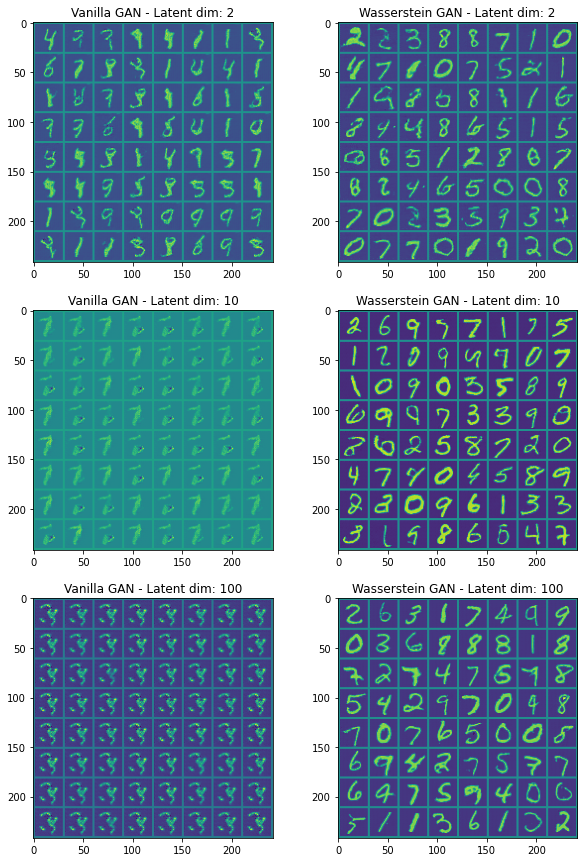

In [9]:

# Define latent space samples
n_samples = 64

plt.figure(figsize=(10,15))
for i, latent_dim in enumerate([2, 10, 100]):
  z = torch.randn(n_samples, latent_dim).to(device)

  # Compute vanilla GAN samples
  vanilla_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
  vanilla_state_dict_path = f'computational_imaging_masterclass/generator_latent_{latent_dim}'
  state_dict = torch.load(vanilla_state_dict_path, map_location=device)
  vanilla_generator.load_state_dict(state_dict)
  vanilla_generated_img = vanilla_generator(z)
  vanilla_generated_img = make_grid(vanilla_generated_img)[0:1]
  vanilla_generated_img = vanilla_generated_img.detach().cpu().numpy()

  # Compute Wasserstein GAN samples
  wasserstein_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
  wasserstein_state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
  state_dict = torch.load(wasserstein_state_dict_path, map_location=device)
  wasserstein_generator.load_state_dict(state_dict)
  wasserstein_generated_img = wasserstein_generator(z)
  wasserstein_generated_img = make_grid(wasserstein_generated_img)[0:1]
  wasserstein_generated_img = wasserstein_generated_img.detach().cpu().numpy()

  # Plotting
  plt.subplot(3,2,2*(i+1)-1)
  plt.imshow(vanilla_generated_img[0])
  plt.title(f'Vanilla GAN - Latent dim: {latent_dim}')
  plt.subplot(3,2,2*(i+1))
  plt.imshow(wasserstein_generated_img[0])
  plt.title(f'Wasserstein GAN - Latent dim: {latent_dim}')
plt.show()




Below, you can how the GANs interpolate a 2-dimensional latent space

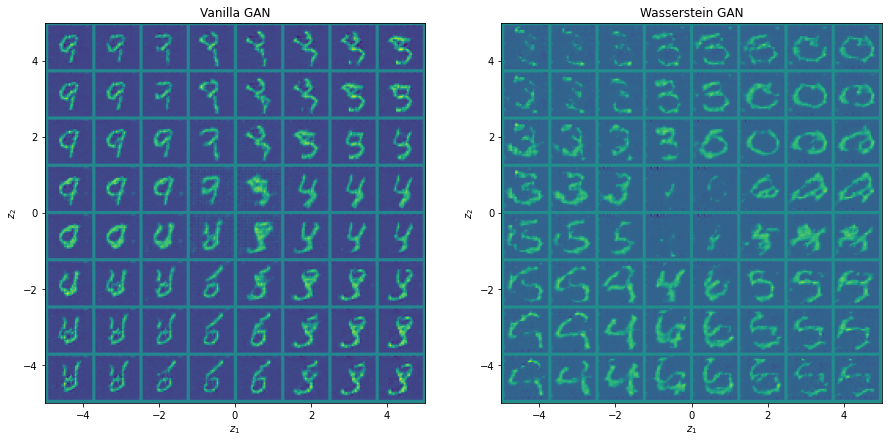

In [11]:
# Set up latent space samples on a grid
latent_dim = 2
num_samples = 8
z_lim = torch.linspace(-5, 5, num_samples)
z_x, z_y = torch.meshgrid(z_lim, z_lim)
z_x, z_y = z_x.flatten(), z_y.flatten()
z = torch.stack([z_x, z_y], dim=1).to(device)

# Load and evaluate vanilla GAN
vanilla_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
vanilla_state_dict_path = f'computational_imaging_masterclass/generator_latent_{latent_dim}'
state_dict = torch.load(vanilla_state_dict_path, map_location=device)
vanilla_generator.load_state_dict(state_dict)
vanilla_generated_img = vanilla_generator(z)
vanilla_generated_img = make_grid(vanilla_generated_img)[0:1]
vanilla_generated_img = vanilla_generated_img.detach().cpu().numpy()

# Load and evaluate Wasserstein GAN
wasserstein_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
wasserstein_state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
state_dict = torch.load(wasserstein_state_dict_path, map_location=device)
wasserstein_generator.load_state_dict(state_dict)
wasserstein_generated_img = wasserstein_generator(z)
wasserstein_generated_img = make_grid(wasserstein_generated_img)[0:1]
wasserstein_generated_img = wasserstein_generated_img.detach().cpu().numpy()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(vanilla_generated_img[0], extent=[z_lim[0], z_lim[-1], z_lim[0], z_lim[-1]])
plt.title('Vanilla GAN')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.subplot(1,2,2)
plt.imshow(wasserstein_generated_img[0], extent=[z_lim[0], z_lim[-1], z_lim[0], z_lim[-1]])
plt.title('Wasserstein GAN')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

# Inverse Problems with GANs

In this section we see how the MCGAN approach can be used to solve inverse problems.

All the code is written, so you just have to play around with it. 

We recommend trying different kind of noise distributions and observation operators.

Again, think about how this can be applied to your own research

In [12]:
# Install Hamiltorch - Hamiltonian monte carlo library
!pip install git+https://github.com/AdamCobb/hamiltorch

  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-345mg69t
  Running command git clone -q https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-345mg69t
  Created wheel for hamiltorch: filename=hamiltorch-0.4.0.dev1-py3-none-any.whl size=20130 sha256=44a39852d5976988da7472e8206203532f2c76882079717113e9c343c28e9a42
  Stored in directory: /tmp/pip-ephem-wheel-cache-og97_c8n/wheels/94/33/56/4cf57b40759f68de688e5e01bee26d036f98048a16a9733e9b
Successfully built hamiltorch


In [39]:
import hamiltorch

def observation_operator(data, obs_idx):
  """Observation operator"""
  
  return data[0, obs_idx[0], obs_idx[1]]

def latent_posterior(z, generator, obs_operator, observations,
                     prior_mean, prior_std, noise_mean, noise_std):
  """Latent space log-posterior"""

  log_prior = torch.distributions.Normal(
      prior_mean,
      prior_std
      ).log_prob(z).sum()

  gen_state = generator(z.view(1, latent_dim))[0]
  gen_state = obs_operator(gen_state)
  error = observations - gen_state

  log_likelihood = torch.distributions.Normal(
      noise_mean,
      noise_std
      ).log_prob(error).sum()

  return log_prior + log_likelihood


def compute_MAP(z, num_iters, posterior):
  """Compute maximum a posteriori estimate"""

  optimizer = optim.Adam([z], lr=1e-2)

  pbar = tqdm(range(num_iters), mininterval=3.,postfix=['Loss', dict(loss="0")])
  for epoch in pbar:

    optimizer.zero_grad()

    neg_log_prob = -posterior(z)

    neg_log_prob.backward()
    optimizer.step()

    pbar.postfix[1] = f"{neg_log_prob.item():.3f}"

  return z

def hamiltonian_MC(z_init,posterior, HMC_params):
  """Compute Hamiltonian Monte Carlo latent space samples"""

  z_samples = hamiltorch.sample(log_prob_func=posterior,
                                params_init=z_init,
                                **HMC_params)
  return torch.stack(z_samples)

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 500/500 [00:06<00:00, 75.56it/s['Loss', '8922.549']]

Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.0020762067288160324

Acceptance Rate 0.37


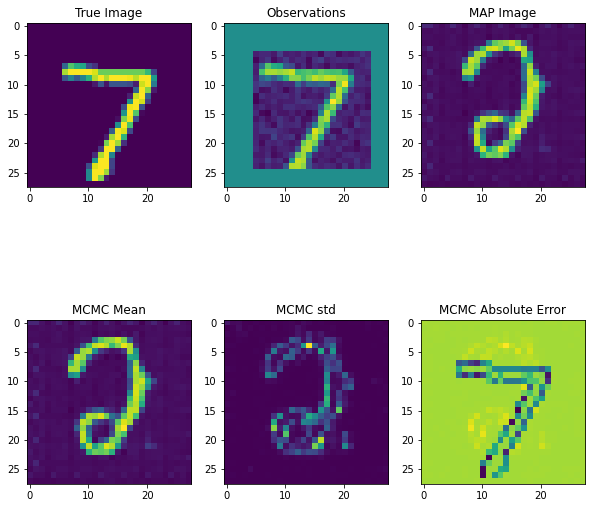

In [42]:
latent_dim = 100

generator = Generator(latent_dim=latent_dim, num_out_channels=1).to(device)
state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
state_dict = torch.load(state_dict_path, map_location=device)
generator.load_state_dict(state_dict)

# Load a test image
test_image = test_dataset[0][0]

# Define observation pixels
obs_x, obs_y = torch.meshgrid(torch.arange(5,25), torch.arange(5,25))
obs_idx = [obs_x.flatten(), obs_y.flatten()]
obs_operator = lambda x: observation_operator(x, obs_idx)

test_observations = obs_operator(test_image)

# Set artificial noise mean and variance
noise_mean = 0.
noise_std = 0.1

# Sample noise from a normal distribution
noise = torch.distributions.Normal(
        noise_mean,
        noise_std
        ).sample_n(len(test_observations.flatten()))

# Add noise to the observations
test_observations += noise.view(test_observations.shape)
test_observations = test_observations.to(device)

# Set posterior parameters
posterior_params = {
    'generator': generator,
    'obs_operator': obs_operator,
    'observations': test_observations,
    'prior_mean': torch.zeros(latent_dim, device=device),
    'prior_std': torch.ones(latent_dim, device=device),
    'noise_mean': noise_mean,
    'noise_std': noise_std
    }
  
# Set Hamiltonian MC parameters
HMC_params = {
    'num_samples': 1000,
    'step_size': 1.,
    'num_steps_per_sample': 5,
    'burn': 750,
    'integrator': hamiltorch.Integrator.IMPLICIT,
    'sampler': hamiltorch.Sampler.HMC_NUTS,
    'desired_accept_rate': 0.3
    }

# Define log posterior as a function of only the latent space
log_posterior = lambda z: latent_posterior(z, **posterior_params)

# Choose initial latent sample
z = torch.randn(1, latent_dim, requires_grad=True, device=device)

# Compute maximum a posteriori latent estimate
z_MAP = compute_MAP(
    z=z, 
    num_iters=500,
    posterior=log_posterior
    )

# Generate full order posterior MAP from latent MAP
gen_MAP = generator(z_MAP)[0].detach().cpu()

# Latent space posterior samples with HMC
z_MCMC = hamiltonian_MC(
    z_init=z_MAP.squeeze(0),
    posterior=log_posterior,
    HMC_params=HMC_params)

# Generate full order posterior samples from latent HMC samples
gen_MCMC = generator(z_MCMC).detach().cpu()

# Compute statistics of posterior samples
gen_MCMC_mean = gen_MCMC.mean(dim=0)
gen_MCMC_std = gen_MCMC.std(dim=0)

# Observation tensor for plotting
obs_plot = torch.zeros(test_image.shape)
obs_plot[:, obs_idx[0], obs_idx[1]] = test_observations.detach().cpu()

# Plot results
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(test_image[0].detach().cpu())
plt.title('True Image')
plt.subplot(2,3,2)
plt.imshow(obs_plot[0].detach().cpu())
plt.title('Observations')
plt.subplot(2,3,3)
plt.imshow(gen_MAP[0])
plt.title('MAP Image')
plt.subplot(2,3,4)
plt.imshow(gen_MCMC_mean[0])
plt.title('MCMC Mean')
plt.subplot(2,3,5)
plt.imshow(gen_MCMC_std[0])
plt.title('MCMC std')
plt.subplot(2,3,6)
plt.imshow(np.abs(gen_MCMC_std[0]-test_image[0].detach().cpu()))
plt.title('MCMC Absolute Error')
plt.show()